In [1]:
METADATA = {
    'title': 'NAIRR Compliance Report',
    'version': 5,
    'description': 'Summary of resource data available for NAIRR.',
    'history': [
        [ '5', '2025-01-22', 'Compliance table data updates.'],
        [ '4', '2025-01-13', 'Add list of metrics and dimensions.'],
        [ '3', '2025-01-13', 'Add notes on data sources.'],
        [ '2', '2024-12-12', 'Add detailed notes on data sources.'],
        [ '1', '2024-11-20', 'Initial Version.']
    ]
}

In [4]:
# Try installing via Python module
!pip install --upgrade pip
!pip install psycopg mysql-connector-python pandas plotly ipython numpy xdmod-data matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ow]


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import of the XDMoD API
from xdmod_data.warehouse import DataWarehouse


# Import of pre-defined plotlyjs chart styles
import xdmod_data.themes

# system packages that are used in this example workbook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
from IPython.display import display, Markdown, JSON, HTML

# Setup plotting defaults
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np

# The timeseries template is provided by the xdmod.themes import
import plotly.io as pio
pio.templates.default = "timeseries"
pio.renderers.default = "plotly_mimetype+notebook"

import plotly.express as px

import pytz

import json
import math
import os
import datetime
import re
from collections import defaultdict

from IPython.display import Javascript

pd.options.display.float_format = "{:,.0f}".format

Matplotlib is building the font cache; this may take a moment.


In [6]:
display(Markdown(f'# {METADATA["title"]}'))
now = datetime.datetime.now()
display(Markdown(f' Report version {METADATA["version"]}. Generated {now}.'))

# NAIRR Compliance Report

 Report version 5. Generated 2025-06-18 07:02:48.082015.

In [7]:
os.environ["XDMOD_API_TOKEN"] = os.environ["NAIRR_WS_DEV_TOKEN"]
XDMOD_URL = "https://nairr-ws-dev.ccr.xdmod.org"
dw = DataWarehouse(XDMOD_URL)

In [8]:
notes = {
    "Amazon Web Services": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "Google Cloud Platform": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "Microsoft Azure": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "Indiana Jetstream2 GPU": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "Purdue Anvil CPU": {
        "logs": True,
        "maps": True,
        "note": "No usage seen in log data"
    },
    "Purdue Anvil GPU": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "TAMU ACES": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "TACC Frontera": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "DOE Oak Ridge National Laboratory Summit": {
        "logs": False,
        "maps": False,
        "note": 'Planned for project phase 1.'
    },
    "TACC Frontera GPU": {
        "logs": True,
        "maps": True,
        "note": ''
     },
    "TACC Lonestar6": {
        "logs": True,
        "maps": True,
        "note": ''
   },
    "TACC Lonestar6 GPU": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "TACC Vista": {
        "logs": True,
        "maps": True,
        "note": ''
    },
    "DOE Argonne National Laboratory AI Testbed": {
        "logs": False,
        "maps": False,
        "note": 'Planned for project phase 1.'
    },
    "SambaNova Suite with Samba 1": {
        "logs": False,
        "maps": False,
        "note": 'Planned for project phase 2.'
    },
    "SDSC Expanse CPU": {
        "logs": False,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "PSC Bridges 2 Regular Memory ": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "SDSC Expanse GPU": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "PSC Bridges 2 GPU ": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "PSC Bridges 2 Extreme Memory": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "NCSA Delta GPU ": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "NVIDIA DGX Cloud": {
        "logs": True,
        "maps": True,
        "note": 'Logs provided on a per-project basis.'
    },
    "NCSA DeltaAI": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "PSC Neocortex ": {
        "logs": True,
        "maps": True,
        "note": 'Mapping information via manually transferred spreadsheet'
    },
    "SDSC Voyager ": {
        "logs": False,
        "maps": False,
        "note": 'Planned for project phase 1.'
    }
}

In [11]:
def compliance(dw, duration):
    compute_resunits = ['Service Units', 'Node Hours', 'Core-hours', 'GPU Hours', 'CS-2 Hours', 'Gaudi-hours']
    
    xras_data_res = {}
    with dw:
        resunits = dw.get_data(
            duration=duration,
            realm='ResourceActions',
            dimension='Resource Unit',
            metric='Total Requested (Resource Units)',
            dataset_type='aggregate'
        )
        for resunit in resunits.index.to_list():
            tmp = dw.get_data(
                duration=duration,
                realm='ResourceActions',
                dimension='Resource',
                metric='Total Requested (Resource Units)',
                dataset_type='aggregate',
                filters={'Resource Unit': [resunit]}
            )
            if resunit in compute_resunits:
                resunit = 'Compute Hours'
            if resunit not in xras_data_res:
                xras_data_res[resunit] = []
            xras_data_res[resunit].extend(tmp.index.to_list())

        tmp = dw.get_data(
            duration=duration,
            realm='Jobs',
            dimension='Resource',
            metric='Number of Jobs Ended',
            dataset_type='aggregate'
        )

        jobs_data = tmp.index.to_list()

        tmp = dw.get_data(
            duration=duration,
            realm='Cloud',
            dimension='Resource',
            metric='CPU Hours: Total',
            dataset_type='aggregate'
        )

        cloud_data = tmp.index.to_list()

        tmp = dw.get_data(
            duration=duration,
            realm='CloudBank Spend',
            dimension='Cloud Provider',
            metric='Total Spend (USD)',
            dataset_type='aggregate'
        )

        cb_data = tmp.index.to_list()
        
    return xras_data_res, jobs_data, cb_data, cloud_data

def bool_print(input):
    if input is None:
        return " "
    if input:
        return '✓'
    else:
        return '<span style="color:red">✗</span>'
        
def pretty_print_compliance(notes):
    xras_res, jobs_res, cb_res, cd_res = compliance(dw, ('2000-01-01', '2026-01-01'))

    output = ""
    output += '| Resource Name | Location of Allocations Information in XDMoD | Location of Usage Information in XDMoD | Allocation Unit Type | Accounting Data Provided to MMS | Mapping Data Provided to MMS | Notes |\n'
    output += '| ------------- | :--------------------: | :---------------: | :-------------: | :-----: | :-----: | ----- |\n'

    for resunit, resource_list in xras_res.items():
        resource_list.sort()
        for resource in resource_list:
            if resource == "No resource preference  Choose for me ":
                continue
            has_usage = ''
            if resource in jobs_res:
                has_usage = 'Jobs realm'
            if resource in cb_res:
                has_usage = 'CloudBank realm'
            if resource in cd_res:
                has_usage = 'Cloud realm'

            
            nb = {
                "logs": False,
                "maps": False,
                "note": 'Planned for project phase 2.'
            }
            
            if resource in notes:
                nb = notes[resource]
            output += f'| {resource} | Resource Actions realm | {has_usage} | {resunit} | {bool_print(nb["logs"])} | {bool_print(nb["maps"])} | {nb["note"]} |\n'

    return output
    
display(Markdown(pretty_print_compliance(notes)))

| Resource Name | Location of Allocations Information in XDMoD | Location of Usage Information in XDMoD | Allocation Unit Type | Accounting Data Provided to MMS | Mapping Data Provided to MMS | Notes |
| ------------- | :--------------------: | :---------------: | :-------------: | :-----: | :-----: | ----- |
| Amazon Web Services | Resource Actions realm | CloudBank realm | Dollars | ✓ | ✓ |  |
| Google Cloud Platform | Resource Actions realm | CloudBank realm | Dollars | ✓ | ✓ |  |
| Microsoft Azure | Resource Actions realm | CloudBank realm | Dollars | ✓ | ✓ |  |
| OpenAI API | Resource Actions realm |  | Dollars | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Cerebras Wafer Scale Engine 2  | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| DOE Argonne National Laboratory AI Testbed | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 1. |
| DOE Oak Ridge National Laboratory Summit | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 1. |
| Indiana Jetstream2 GPU | Resource Actions realm | Cloud realm | Compute Hours | ✓ | ✓ |  |
| NCSA Delta GPU | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| NCSA DeltaAI | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ | Mapping information via manually transferred spreadsheet |
| NVIDIA DGX Cloud | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ | Logs provided on a per-project basis. |
| PSC Bridges 2 Extreme Memory  | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| PSC Bridges 2 GPU  | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ | Mapping information via manually transferred spreadsheet |
| PSC Bridges 2 Regular Memory  | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ | Mapping information via manually transferred spreadsheet |
| Purdue Anvil AI | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Purdue Anvil CPU | Resource Actions realm |  | Compute Hours | ✓ | ✓ | No usage seen in log data |
| Purdue Anvil GPU | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ |  |
| SDSC Expanse CPU | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | ✓ | Mapping information via manually transferred spreadsheet |
| SDSC Expanse GPU | Resource Actions realm |  | Compute Hours | ✓ | ✓ | Mapping information via manually transferred spreadsheet |
| SDSC Voyager  | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 1. |
| SambaNova Suite  | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| TACC Frontera | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ |  |
| TACC Frontera GPU | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ |  |
| TACC Lonestar6 | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ |  |
| TACC Lonestar6 GPU | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ |  |
| TACC Vista  | Resource Actions realm |  | Compute Hours | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| TAMU ACES | Resource Actions realm | Jobs realm | Compute Hours | ✓ | ✓ | Mapping information via manually transferred spreadsheet |
| Anthropic Model API | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| EleutherAI Collaborations | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Groq LPU Inference Engine | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Hugging Face Spaces and Compute Grants | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| OpenMined Collaborations | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Weights   Biases MLOps Platform | Resource Actions realm |  | [Yes = 1, No = 0] | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| NIH Cloud Lab | Resource Actions realm |  | Number of Students | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Prototype National Research Platform  | Resource Actions realm |  | Number of Students | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |
| Vocareum AI Notebook | Resource Actions realm |  | Number of Students | <span style="color:red">✗</span> | <span style="color:red">✗</span> | Planned for project phase 2. |


## Data Sources

| Realm   |    Data sources  | Notes |
| ------- | ---------------- | ----- |
| Resource Actions | NAIRR XRAS | Metrics ingest data from a read-only mirror of the NAIRR XRAS database. The mirror copy is synced daily |
| Jobs    | Resource Manager Logs; Username mapping; Project mapping | The resource manager logs vay according to the resource. For resources that use Slurm we use the <code>sacct</code> command to export the log data. Username mapping; Project mapping |
| Cloud   | Openstack Logs; Username mapping; Project mapping | Custom script that queries the OpenStack database and encodes in JSON interchange format. |
| CloudBank | CloudBank API; Username mapping; Project mapping | Metrics query a CloudBank API endpoint daily to retrieve information about the spend on the varous CloudBank managed projects | |

In [13]:

def display_df_md_table(df):
    return display(HTML(df.replace('<br/>', '', regex=True).to_html(index=False)))

display(HTML("<hl />"))
display(Markdown("# Appendix A. Metrics and Dimensions available NAIRR XDMoD"))

table_idx = 1

def print_realm_info(realm):
    global table_idx

    display(Markdown(f"## {realm} realm."))
    with dw:
        metrics = dw.describe_metrics(realm)
    metrics = metrics[~metrics['label'].str.contains('Utilization')]
    display(Markdown(f"_Table A{table_idx}. Aggregate Metrics available in the {realm} realm._"))
    display_df_md_table(metrics)
    table_idx += 1
    
    with dw:
        dimensions = dw.describe_dimensions(realm)

    dimensions = dimensions[~dimensions['label'].str.contains('Hierarchy')]
    display(Markdown(f"_Table A{table_idx}. Dimensions available in the {realm} realm. Any metric can be grouped or filtered by the following dimensions._"))
    display_df_md_table(dimensions)
    table_idx += 1

    try:
        with dw:
            raw_fields = dw.describe_raw_fields(realm)
        raw_fields = raw_fields[~raw_fields['label'].str.contains('Hierarchy')]
        display(Markdown(f"_Table A{table_idx}. Per job metrics available in the {realm} realm._"))
        display_df_md_table(raw_fields)
        table_idx += 1
    except Exception:
        pass

print_realm_info('Jobs')
print_realm_info('Cloud')
print_realm_info('CloudBankSpend')
print_realm_info('Resource Actions')


# Appendix A. Metrics and Dimensions available NAIRR XDMoD

## Jobs realm.

_Table A1. Aggregate Metrics available in the Jobs realm._

label,description
CPU Hours: Per Job,"The average CPU hours (number of CPU cores x wall time hours) per NAIRR job.For each job, the CPU usage is aggregated. For example, if a job used 1000 CPUs for one minute, it would be aggregated as 1000 CPU minutes or 16.67 CPU hours."
CPU Hours: Total,"The total CPU hours (number of CPU cores x wall time hours) used by NAIRR jobs.For each job, the CPU usage is aggregated. For example, if a job used 1000 CPUs for one minute, it would be aggregated as 1000 CPU minutes or 16.67 CPU hours."
GPU Count: Per Job,The average job size per NAIRR job.<br><i>Job Size: </i>The number of GPUs used by a (parallel) job.
GPU Hours: Per Job,"The average GPU hours (number of GPU cores x wall time hours) per NAIRR job.For each job, the GPU usage is aggregated. For example, if a job used 1000 GPUs for one minute, it would be aggregated as 1000 GPU minutes or 16.67 GPU hours."
GPU Hours: Total,"The total GPU hours (number of GPUs x wall time hours) used by NAIRR jobs.For each job, the GPU usage is aggregated. For example, if a job used 1000 GPUs for one minute, it would be aggregated as 1000 GPU minutes or 16.67 GPU hours."
Job Size: Max (Core Count),The maximum size NAIRR job in number of cores.<i>Job Size: </i>The total number of processor cores used by a (parallel) job.
Job Size: Min (Core Count),The minimum size NAIRR job in number of cores.<i>Job Size: </i>The total number of processor cores used by a (parallel) job.
Job Size: Normalized (% of Total Cores),"The percentage average size NAIRR job divided by the total number of cores in the resource where the job ran. The job normalization calculation assumes that the resource size is constant. This statistic should not be used with a time range where the resource size changes, because the statistic will be incorrect.<br><i>Normalized Job Size: </i>The ratio of the total number of processor cores used by a (parallel) job over the total number of cores on the resource."
Job Size: Per Job (Core Count),The average job size per NAIRR job.<br><i>Job Size: </i>The number of processor cores used by a (parallel) job.
Job Size: Weighted By CPU Hours (Core Count),The average NAIRR job size weighted by CPU Hours. Defined as <br><i>Average Job Size Weighted By CPU Hours: </i> sum(i = 0 to n){ job i core count * job i cpu hours}/sum(i = 0 to n){job i cpu hours}


_Table A2. Dimensions available in the Jobs realm. Any metric can be grouped or filtered by the following dimensions._

label,description
None,Summarizes Jobs data reported to the NAIRR database.
Allocation,A funded project that is allowed to run jobs on resources.
Field of Science,The field of science indicated on the allocation request pertaining to the running jobs.
GPU Count,A categorization of jobs into discrete groups based on the number of GPUs used by each job.
Job Size,A categorization of jobs into discrete groups based on the number of cores used by each job.
Job Wait Time,A categorization of jobs into discrete groups based on the total linear time each job waited.
Job Wall Time,A categorization of jobs into discrete groups based on the total linear time each job took to execute.
NSF Directorate,The NSF directorate of the field of science indicated on the allocation request pertaining to the running jobs.
Node Count,A categorization of jobs into discrete groups based on node count.
PI,The principal investigator of a project.


_Table A3. Per job metrics available in the Jobs realm._

label,description
Local Job Id,The unique identifier assigned to the job by the job scheduler.
Resource,The resource that ran the job.
Service Provider,The organization of the resource that ran the job.
Timezone,The timezone of the resource.
System Username (Deidentified),The username on the resource of the user that ran the job. May be a UID or string username depending on the resource.
User,The name of the job owner.
User Institution,The organization of the person who ran the task
Principal Investigator,The name of the PI assigned to the job.
PI Institution,The institution of the PI assigned to the job
Quality of Service,The job quality of service.


## Cloud realm.

_Table A4. Aggregate Metrics available in the Cloud realm._

label,description
Average Cores Reserved Weighted By Wall Hours,"The average number of cores reserved by VM's, weighted by wall hours.<b>Core Hours</b>: The product of the number of cores assigned to a VM and its wall time, in hours.<b>Wall Time:</b> The duration between the start and end times of an individual session."
Average Memory Reserved Weighted By Wall Hours (Bytes),"The average amount of memory (in bytes) reserved by VM's, weighted by wall hours.<b>Wall Time:</b> The duration between the start and end times of a VM."
Average Root Volume Storage Reserved Weighted By Wall Hours (Bytes),"The average amount of root volume storage space (in bytes) reserved by VM's, weighted by wall hours.<b>Wall Time:</b> The duration between the start and end times of an individual session."
CPU Hours: Total,"The total number of CPU Hours consumed by VM's<b>CPU Hours</b>: The product of the number of cores assigned to a VM and its wall time, in hours."
Number of PIs: Active,The total number of PIs associated with Projects that used cloud resources.
Number of Projects: Active,The total number of projects that used cloud resources.
Number of Resources: Active,The total number of active cloud resources.
Number of Sessions Active,"The total number of sessions on a cloud resource.<b>Session:</b> A session is defined as a discrete run of a virtual machine (VM) on a cloud resource; i.e. any start and stop of a VM. For example, if a single VM is stopped and restarted ten times in a given day, this would be counted as ten sessions for that day.<b>Start:</b> A session start event is defined as the initial creation, resume from pause/suspension, or unshelving of a VM. In the event that no such event has been collected, the first heartbeat event (e.g. a state report) is treated as the start of a new session.<b>Stop:</b> A session stop event is defined as a pause, shelving, suspension, or termination event of a VM."
Number of Sessions Ended,"The total number of sessions that were ended on a cloud resource. A session is ended when a VM is paused, shelved, stopped, or terminated on a cloud resource.<b>Session:</b> A session is defined as a discrete run of a virtual machine (VM) on a cloud resource; i.e. any start and stop of a VM. For example, if a single VM is stopped and restarted ten times in a given day, this would be counted as ten sessions for that day.<b>Start:</b> A session start event is defined as the initial creation, resume from pause/suspension, or unshelving of a VM. In the event that no such event has been collected, the first heartbeat event (e.g. a state report) is treated as the start of a new session.<b>Stop:</b> A session stop event is defined as a pause, shelving, suspension, or termination event of a VM."
Number of Sessions Started,"The total number of sessions started on a cloud resource. A session begins when a VM is created, unshelved, or resumes running on a cloud resource.<b>Session:</b> A session is defined as a discrete run of a virtual machine (VM) on a cloud resource; i.e. any start and stop of a VM. For example, if a single VM is stopped and restarted ten times in a given day, this would be counted as ten sessions for that day.<b>Start:</b> A session start event is defined as the initial creation, resume from pause/suspension, or unshelving of a VM. In the event that no such event has been collected, the first heartbeat event (e.g. a state report) is treated as the start of a new session.<b>Stop:</b> A session stop event is defined as a pause, shelving, suspension, or termination event of a VM."


_Table A5. Dimensions available in the Cloud realm. Any metric can be grouped or filtered by the following dimensions._

label,description
None,Summarizes Cloud data reported to the NAIRR database.
Domain,"A domain is a high-level container for projects, users and groups"
Field of Science,The field of science indicated on the allocation request pertaining to the running jobs.
Instance Type,The instance type of a virtual machine.
NSF Directorate,The NSF directorate of the field of science indicated on the allocation request pertaining to the running jobs.
PI,The principal investigator of a project.
PI Institution,Organizations that have PIs with allocations.
Parent Science,The parent of the field of science indicated on the allocation request pertaining to the running jobs.
Project,The project associated with a VM.
Provider,A service provider is an institution that hosts resources.


_Table A6. Per job metrics available in the Cloud realm._

label,description
Instance ID,The UUID of the VM
Resource,The resource that ran the job.
Service Provider,The organization of the resource that ran the job.
System Username (Deidentified),The username on the resource of the user that ran the job. May be a UID or string username depending on the resource.
User,The name of the job owner.
User Institution,The institution of the VM owner.
NSF Directorate,The NSF directorate of the field of science indicated on the allocation request pertaining to the running jobs.
Parent Science,The parent of the field of science indicated on the allocation request pertaining to the running jobs.
Field of Science,The field of science indicated on the allocation request pertaining to the running jobs.
Project,The name of the project the VM is assigned to.


## CloudBankSpend realm.

_Table A7. Aggregate Metrics available in the CloudBankSpend realm._

label,description
Number of Cloud Accounts: Active,The total number of cloud accounts that spent money on public cloud services. Money is deposited into a fund from which it is dispersed to cloud provider accounts to cover charges for usage.
Number of Funds: Active,The total number of funds that spent money on public cloud services. Money is deposited into a fund from which it is dispersed to cloud provider accounts to cover charges for usage.
Number of PIs: Active,The total number of principal investigators on the fund(s) that spent money on public cloud services.
Total Spend (USD),The amount of money (in USD) spent by funds on public cloud services.


_Table A8. Dimensions available in the CloudBankSpend realm. Any metric can be grouped or filtered by the following dimensions._

label,description
None,Information about funds that spent money on public cloud services via the NSF CloudBank project.
Cloud Location,The geographical location where cloud providers cluster data centers to provide services.
Cloud Provider,"A provider of cloud services e.g., Amazon Web Services (AWS), Microsoft Azure, Google Cloud Platform (GCP)."
Cloud Provider Account,A cloud provider specific financial account that is charged for usage.
Cloud Service,The particular cloud provider service on which funds spent money.
Cloud Sub-Service,"Within each cloud service there may be one or more sub-services that are charged at different rates (e.g., when using AWS's EC2 service, in addition to being charged for instance time, you are also charged for data transfer, file storage etc. These are seen as sub-services of the EC2 service)."
CloudBank PI,The principal investigator on the fund that spent money on public cloud services.
Co-PI,A co-principal investigator on the fund that spent money on public cloud services.
Field of Science,The branch of science under which a fund's research falls.
Fund,The fund that spent money on public cloud services. Money is deposited into a fund from which it is dispersed to cloud-specific accounts to cover charges for usage.


## Resource Actions realm.

_Table A9. Aggregate Metrics available in the Resource Actions realm._

label,description
Number of PIs,The total number of PIs associated with requests for resources.
Number of Projects,The total number of projects associated with requests for resources.
Number of Resources,The total number of resources associated with requests.
Total Awarded (Resource Units),The total amount of awarded resource units.
Total Recommended (Resource Units),The total amount of recommended resource units.
Total Requested (Resource Units),The total amount of requested resource units.


_Table A10. Dimensions available in the Resource Actions realm. Any metric can be grouped or filtered by the following dimensions._

label,description
None,Summarizes Resource Actions data reported to the NAIRR database.
Opportunity,The opportunity associated with the project request.
Project Action Status,The status of the action associated with a request. Incomplete requests are not included in the data.
Project Action Type,The type of project action.
Project Identifier,The identifier in XRAS associated with a project.
Project PI,THe PI of the project at the point in time that the project action occurred.
Project Request Type,The type of the request associated with a project
Project Type,The project allocation category.
Resource,A resources is a CI entity that can be allocated.
Resource Type in XRAS,The type of the resource as categorized in the XRAS database.


_Table A11. Per job metrics available in the Resource Actions realm._

label,description
Resource,The Resource
Project Identifier,The project identifier
PI first Name,Project PI First Name
PI Last Name,Project PI Last Name
PI Email,Project PI email address
Allocation Begin Date,The start date of the allocation
Allocation End Date,The end date of the allocation


In [14]:
changelog = """
# Document Version History
| Version | Date  | Notes |
| ------- | ----- | ----- |
"""

for entry in METADATA['history']:
    changelog += "| " + " | ".join(entry) + " |\n"

display(Markdown(changelog))


# Document Version History
| Version | Date  | Notes |
| ------- | ----- | ----- |
| 5 | 2025-01-22 | Compliance table data updates. |
| 4 | 2025-01-13 | Add list of metrics and dimensions. |
| 3 | 2025-01-13 | Add notes on data sources. |
| 2 | 2024-12-12 | Add detailed notes on data sources. |
| 1 | 2024-11-20 | Initial Version. |


---
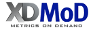 XDMoD Data Analytics Framework v1.0.1